In [62]:
import pandas as pd
import numpy as np
from processing.groundtruth import GroundTruthReplay

In [63]:
csv_path = "../dataset/town3_5/vehicle_coordinates.csv"
ego_id = 62
gt_replay = GroundTruthReplay(csv_path, ego_id)

In [64]:

from processing.datareader import load_imu_data, load_radar_config, load_radar_data
from processing.radarproc import RpcReplay


def prepare_experiment_data(datadir: str, ego_id: int) -> RpcReplay:
    """
    Loads rpc data structure designed for easy fetching and indexing of recorded simulation data.
    
    :param str datadir: absolute or relative path to the dataset root
    :param int ego_id: id of the ego vehicle set by the carla simulator
    :return rpc_replay: RpcReplay object
    """
    rpc, frame_ids = load_radar_data(datadir)
    imu_df = load_imu_data(f"{datadir}/imu_data.csv", ego_id)
    # nearby_df, ego_traj, frame_ids = load_and_prepare_data(config.sim.datadir, config.sim.ego_id)
    sensor_transforms = load_radar_config(datadir)
    rpc_replay = RpcReplay(rpc, frame_ids, sensor_transforms, imu_df)
    return rpc_replay


In [65]:
from pipepine.factory import RpcProcessFactory


rpc_replay = prepare_experiment_data("../dataset/town3_5/", ego_id=ego_id)
processing_factory = RpcProcessFactory(rpc_replay)

In [66]:
rpc_config = {"spatial_eps": 2, "velocity_eps": 1, "min_samples": 4, "velocity_weight": 5}

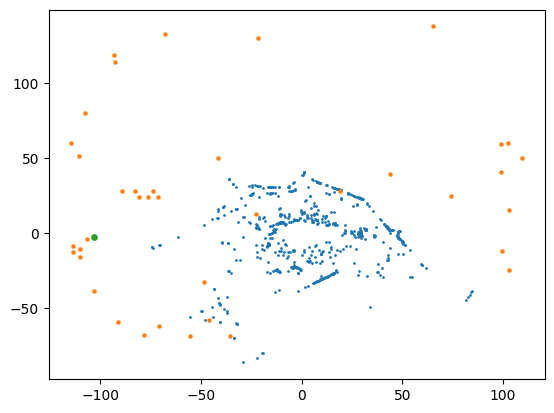

In [67]:
import matplotlib.pyplot as plt

index = 1000
gt = gt_replay.get_frame_data(index).all_vehicles[['x', 'y', 'z']].values
ego_vehicle = gt_replay.get_frame_data(index).ego_vehicle[['x', 'y', 'z']].values
rpc = processing_factory.get_processed_frame(idx=index, **rpc_config)[1].point_cloud

plt.scatter(x=rpc[:, 0], y=rpc[:, 1], s=1)
plt.scatter(x=gt[:, 0], y=gt[:, 1], s=5)
plt.scatter(x=ego_vehicle[:, 0], y=ego_vehicle[:, 1], s=15)

In [68]:
print(ego_vehicle.shape)
print(gt.shape)

(1, 3)
(40, 3)


In [69]:
index=850

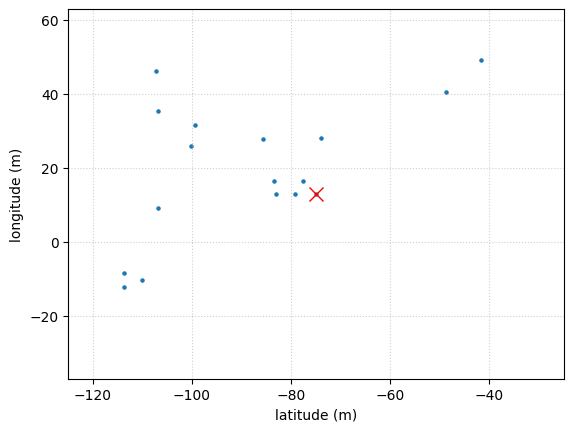

In [70]:
import matplotlib.pyplot as plt


ego_vehicle = gt_replay.get_frame_data(index).ego_vehicle[['x', 'y', 'z']].values
gt = gt_replay.get_frame_data(index).all_vehicles[['x', 'y', 'z']].values

center_x, center_y = ego_vehicle[:,0], ego_vehicle[:,1]
limit = 50
plt.xlim(center_x - limit, center_x + limit)
plt.ylim(center_y - limit, center_y + limit)
plt.grid(True, linestyle=':', alpha=0.6)

plt.xlabel("latitude (m)")
plt.ylabel("longitude (m)")
plt.scatter(x=gt[:, 0], y=gt[:, 1], s=5)
plt.plot(ego_vehicle[:, 0], ego_vehicle[:, 1], 'rx', markersize=10, label="Ego Vehicle (0,0)")

In [71]:
class VehiclePosition:
    def __init__(self, point: np.ndarray):
        point = point.reshape(-1)
        self.x = point[0]
        self.y = point[1]
        self.z = point[2]

In [72]:
def rotate_vehicle(ego_yaw: int, ego: VehiclePosition, target_vehicle: VehiclePosition):
    diff_x = target_vehicle.x - ego.x
    diff_y = target_vehicle.y - ego.y

    theta = np.radians(-ego_yaw) 
    local_x = diff_x * np.cos(theta) - diff_y * np.sin(theta)
    local_y = diff_x * np.sin(theta) + diff_y * np.cos(theta)
    
    return np.array([local_x, local_y])

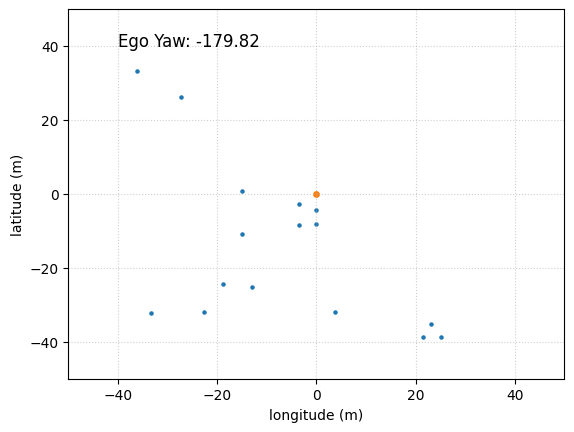

In [73]:
import matplotlib.pyplot as plt


ego_vehicle = gt_replay.get_frame_data(index).ego_vehicle[['x', 'y', 'z']].values
gt = gt_replay.get_frame_data(index).all_vehicles[['x', 'y', 'z']].values - ego_vehicle
ego_vehicle = ego_vehicle - ego_vehicle
ego_yaw = gt_replay.get_frame_data(index).ego_vehicle['yaw'].values[0]

gt = [
    rotate_vehicle(
        ego_yaw=ego_yaw, 
        ego=VehiclePosition(ego_vehicle), 
        target_vehicle=VehiclePosition(gt[i,:])
        )
    for i in range(len(gt))
]
gt = np.array(gt)

limit = 50
plt.grid(True, linestyle=':', alpha=0.6)
plt.xlim(-limit, limit)
plt.ylim(-limit, limit)
plt.text(-40, 40, f"Ego Yaw: {ego_yaw:.2f}", fontsize=12)

plt.ylabel("latitude (m)")
plt.xlabel("longitude (m)")
plt.scatter(y=-gt[:, 0], x=gt[:, 1], s=5)
plt.scatter(y=ego_vehicle[:, 0], x=ego_vehicle[:, 1], s=15)